# Defining Fault Sampling Approaches in fmdtools

Fault Sampling is used to evaluate the overall resilience of a system to a set of faults and the corresponding risks associated with these faults. There is no single best way to define the set of scenarios to evaluate resilience with, because a given resilience analysis may need more or less detail, support more or less computational time, or be interested in specific scenario types of interest.

Thus, there are a number of use-cases supported by fmdtools for different sampling models. This document will demonstrate and showcase a few of them.

In [1]:
import sys
# for use in development - makes sure git version is used instead of pip-installed version
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop


### Basics

Fault sampling involves:
- Defining faults and fault models within each function/component of the model (using the `.assoc_modes()` method)
- Defining a fault sampling approach (using the `SampleApproach` class)
- Propagating faults through the model (using the `propagate.approach` method)
Before proceeding, it can be helpful to look through their respective documentation.

In [2]:
help(FxnBlock.assoc_modes)

Help on function assoc_modes in module fmdtools.modeldef:

assoc_modes(self, faultmodes={}, opermodes=[], initmode='nom', name='', probtype='rate', units='hr', exclusive=False, key_phases_by='none')
    Associates fault and operational modes with the block when called in the function or component.
    
    Parameters
    ----------
    faultmodes : dict, optional
        Dictionary/Set of faultmodes with structure, which can have the forms:
            - set {'fault1', 'fault2', 'fault3'} (just the respective faults)
            - dict {'fault1': faultattributes, 'fault2': faultattributes}, where faultattributes is:
                - float: rate for the mode
                - [float, float]: rate and repair cost for the mode
                - float, oppvect, float]: rate, opportunity vector, and repair cost for the mode
                opportunity vector can be specified as:
                    [float1, float2,...], a vector of relative likelihoods for each phase, or
                  

In [3]:
help(SampleApproach)

Help on class SampleApproach in module fmdtools.modeldef:

class SampleApproach(builtins.object)
 |  SampleApproach(mdl, faults='all', phases='global', modephases={}, jointfaults={'faults': 'None'}, sampparams={}, defaultsamp={'samp': 'evenspacing', 'numpts': 1})
 |  
 |  Class for defining the sample approach to be used for a set of faults.
 |  
 |  Attributes
 |  ----------
 |  phases : dict
 |      phases defined in the model
 |  tstep : float
 |      timestep defined in the model
 |  fxnrates : dict
 |      overall failure rates for each function
 |  comprates : dict
 |      overall failure rates for each component
 |  jointmodes : list
 |      (if any) joint fault modes to be injected in the approach
 |  rates : dict
 |      rates of each mode (fxn, mode) in each model phase, structured {fxnmode: {(phasetype, phase):rate}}
 |  sampletimes : dict
 |      faults to inject at each time in each phase, structured {(phasetype, phase):time:fnxmode}
 |  weights : dict
 |      weight to pu

In [5]:
help(prop.approach)

Help on function approach in module fmdtools.faultsim.propagate:

approach(mdl, app, staged=False, track='all', pool=False, showprogress=True)
    Injects and propagates faults in the model defined by a given sample approach
    
    Parameters
    ----------
    mdl : model
        The model to inject faults in.
    app : sampleapproach
        SampleApproach used to define the list of faults and sample time for the model.
    staged : bool, optional
        Whether to inject the fault in a copy of the nominal model at the fault time (True) or instantiate a new model for the fault (False). Setting to True roughly halves execution time. The default is False.
    track : str ('all', 'functions', 'flows', 'valparams', dict, 'none'), optional
        Which model states to track over time, which can be given as 'functions', 'flows', 
        'all', 'none', 'valparams' (model states specified in mdl.valparams),
        or a dict of form {'functions':{'fxn1':'att1'}, 'flows':{'flow1':'att1'}

### Model Setup

Consider the following (highly simplified) rover electrical/navigation model. We can define the functions of this rover using the classes:

In [7]:
class Move_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, flownames={"EE":"EE_in"})
        self.assoc_modes({"mech_loss", "elec_open"})
    def behavior(self, time):
        if self.time < time:
            power = self.EE_in.v_supply * self.Control.vel *self.no_fault("elec_open")
            self.EE_in.a_supply = power/12
            if power >100: self.add_fault("elec_open")
            else:          self.Ground.x = self.Ground.x + power*self.no_fault("mech_loss")

This use of `assoc_modes` specifies that there are two modes to inject, "mech_loss", and "elec_open", with no more information given for each mode. This is a syntax one might use as one is constructing the model and wishing to verify behaviors, or where modes are only caused behaviorally due to external scenarios. (in this case an open circuit is caused by too much power supply)

In [ ]:
class Control_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows)
        self.assoc_modes({'no_con':[1e-4, 200]}, ['drive','standby'], initmode='standby')
    def behavior(self,time):
        if not self.in_mode('no_con'):
            if time == 5: self.set_mode('drive')
            if time == 50: self.set_mode('standby')
        if time>self.time:
            if self.in_mode('drive'):
                self.Control.power = 1
                self.Control.vel = 1
            elif self.in_mode('standby'):
                self.Control.vel = 0
                self.Control.power=0

This use of `assoc_modes` specifies modes (`no_con`) with a rate (1e-4) and a repair cost (200), as well as a set of operational modes that the system proceeds through. Specifying operational modes enables one to define different *behaviors* for the system depending on the configuration of the system at a given time. For example, in this function, the system goes into a drive mode at t=5, which powers on the system and outputs a command to move forward. 

When operational modes are specified in the model, an initial mode must also be specified--in this case `initmode='standby'` specifies that the function starts in the standby mode.

In [6]:
class Store_Energy(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows, states={"charge": 100})
        self.assoc_modes({"no_charge":[1e-5, {'standby':1.0}, 100],"short":[1e-5, {'supply':1.0}, 100],}, ["supply","charge","standby"], initmode="standby", exclusive = True, key_phases_by='self')
    def behavior(self,time):
        if time > self.time:
            if self.in_mode("standby"):     
                self.EE.v_supply = 0; self.EE.a_supply = 0
                if self.Control.power==1: self.set_mode("supply")
            elif self.in_mode("charge"):    
                self.EE.charge =min(self.EE.charge+self.tstep, 20)
            elif self.in_mode("supply"):
                if self.charge > 0:         self.EE.v_supply = 12; self.charge -= self.tstep
                else: self.set_mode("no_charge")
                if self.Control.power==0: self.set_mode("standby")
            elif self.in_mode("short"):     self.EE.v_supply = 100; self.charge = 0
            elif self.in_mode("no_charge"): self.EE.v_supply=0

In addition to operational modes, the Battery Function additionally specifies an *opportunity vector* which defines when each fault mode is likely to occur (and thus be injected in the model). In this case, `no_charge` can only occur during standby mode, while a `short` can only occur during the supply mode. The  `key_phases_by='self'` option specifies that these phases are *internal* to the function. Opporunity vectors can also be keyed to phases in other functions using `key_phases_by='fxnname'` and `key_phases_by='global'`. There are several ways to define this opportunity vector, which will be described later.

This model also uses the `exclusive` option, which specifies that fault modes cannot co-occur with operational modes. That is, instead of *modifying* individual mode behaviors, fault modes in this function instead cause the system to enter a new mode with different defined mode behaviors. 


In [8]:
class Rover(Model):
    def __init__(self, params={},\
                 modelparams={'times':[0,60], 'tstep':1, 'phases': {'firsthalf':[0,30], 'secondhalf':[31,60]}},\
                 valparams={}):
        super().__init__(params, modelparams, valparams)
        
        self.add_flow('Ground', {'x':0,'y':0, 'dir':0, 'vel':0})
        self.add_flow('EE', {'v_supply':0, 'a_supply':0})
        self.add_flow('Control', {'dir':0, 'vel':0, 'power':0})
        
        self.add_fxn("Control_Rover",["EE", "Control"], fclass=Control_Rover)
        self.add_fxn("Move_Rover", ["Ground","EE", "Control"], fclass = Move_Rover)
        self.add_fxn("Store_Energy", ["EE", "Control"], Store_Energy)
        
        self.construct_graph()

`"global"` phases in the model are defined using the 'phases' string in model parameters. Phases define distinct periods or activities of operation when the model may be in a different state (resulting in different potential failure mode effects and opportunities for failure modes to be entered).

### Setting up an approach

Because this model has an opportunity vector which is keyed by its operational modes, the history of modes needs to be generated for the model to set up the sample approach--otherwise this information cannot be used, as shown below:

In [10]:
mdl = Rover()
app = SampleApproach(mdl)

KeyError: 'Store_Energy'

To form this history, the model is run in the nominal scenario, as shown.

In [16]:
endclass , resgraph,mdlhist = prop.nominal(mdl)
mdlhist['functions']['Store_Energy']

{'faults': array(['nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom',
        'nom', 'nom', 'nom', 'nom', 'nom', 'nom', 'nom'], dtype=object),
 'charge': array([100, 100, 100, 100, 100, 100,  99,  98,  97,  96,  95,  94,  93,
         92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,  81,  80,
         79,  78,  77,  76,  75,  74,  73,  72,  71,  70,  69,  68,  67,
         66,  65,  64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  55,
         55,  55,  55,  55,  55,  55,  55,  55,  55]),
 'mode': array(['standby', 'standby', 'standby', 'standby', 'standby', 'supply',
        'supply', 'supply', 'supply', 'supply', 'supp

To get the phase information, the 'process.modephases' method is used.

In [19]:
phases, modephases = rd.process.modephases(mdlhist)

Which returns `phases`, the phases of operation for each function where operational modes were defined:

In [21]:
phases

{'Control_Rover': {'standby': [0, 4], 'drive': [5, 49], 'standby1': [50, 60]},
 'Store_Energy': {'standby': [0, 4], 'supply': [5, 49], 'standby1': [50, 60]}}

as well as `modephases`, which lists the phases associated with each mode.

In [23]:
modephases

{'Control_Rover': {'standby': {'standby', 'standby1'}, 'drive': {'drive'}},
 'Store_Energy': {'standby': {'standby', 'standby1'}, 'supply': {'supply'}}}

To correctly sample according to the fault model's intent (that each fault can occur within each `mode`), SampleApproach is given both `phases` and `modephases`, as shown below.

In [38]:
app_correct = SampleApproach(mdl, phases=phases, modephases=modephases)
app_correct.sampletimes

{('none',
  'operating'): {30: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'mech_loss'),
   ('Move_Rover', 'elec_open')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'standby1'): {54: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

In [39]:
app_incorrect = SampleApproach(mdl, phases=phases)
app_incorrect.sampletimes

{('none',
  'operating'): {30: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'mech_loss'),
   ('Move_Rover', 'elec_open')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

As shown, in the first sampleapproach, only the first phases of the mode are sampled, and not the second phases, because there is nothing to tell the approach which phases are associated with which mode, and the opportunity vector was keyed by modes. However, there are cases where it may not be necessary to provide `modephases` when providing , specifically:
- If the opportunity vector is defined in terms of local `phases` directly instead of `modes`, (e.g. by `{standby`:rate, `supply`:rate, `standby1`:rate}))
- If only the first phase is of interest
- If all fault modes are keyed by `global` phases

Note that presently, joint fault modes can only be sampled when the opportunity vectors for each mode are defined using the global phase. See:

In [41]:
app_joint = SampleApproach(mdl, phases=phases, modephases=modephases, jointfaults = {'faults':2})

KeyError: ('global', 'firsthalf')

Additionally, note how different opportunity vectors lead to different sample approaches:

In [46]:
app_correct.sampletimes

{('none',
  'operating'): {30: [('Control_Rover', 'no_con'),
   ('Move_Rover', 'mech_loss'),
   ('Move_Rover', 'elec_open')]},
 ('Store_Energy', 'standby'): {2: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'standby1'): {54: [('Store_Energy', 'no_charge')]},
 ('Store_Energy', 'supply'): {27: [('Store_Energy', 'short')]}}

- `Move_Rover`, and `Control_Rover`, where no opportunity vector was provided, are sampled once in the middle of an `operating` phase
- `Store_Energy` is sampled once in each given phase (defined itself).
- None of the modes are sampled during the global phases (although they could be, if that was provided in the function defintion)

### Propagating Faults

Given the fault sampling approach, the faults can then be propagated through the model to get results. Note that these faults can be sampled in parallel if desired using a user-provided pool (see the parallel pool tutorial in the `\pump example` folder).

In [50]:
endclasses, mdlhists = prop.approach(mdl, app_correct)

SCENARIOS COMPLETE: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 341.58it/s]


In [51]:
endclasses

{'Control_Rover no_con, t=30': {'rate': 0.006,
  'cost': 1,
  'expected cost': 0.006},
 'Move_Rover mech_loss, t=30': {'rate': 30.0,
  'cost': 1,
  'expected cost': 30.0},
 'Move_Rover elec_open, t=30': {'rate': 30.0,
  'cost': 1,
  'expected cost': 30.0},
 'Store_Energy no_charge, t=2': {'rate': 2e-05,
  'cost': 1,
  'expected cost': 2e-05},
 'Store_Energy no_charge, t=54': {'rate': 5e-05,
  'cost': 1,
  'expected cost': 5e-05},
 'Store_Energy short, t=27': {'rate': 0.00044,
  'cost': 1,
  'expected cost': 0.00044}}

Note that the results here reflect the lack of information given for rates in the `Control_Rover` and `Move_Rover` functions (which default to a value of 1) and the rates do not correspond *direct* to the given rates because rates shown here are per-run rates which are spread over the model. Additionally, all scenarios default to a cost of 1 because of the lack of a classification function.

These responses can be visualized:

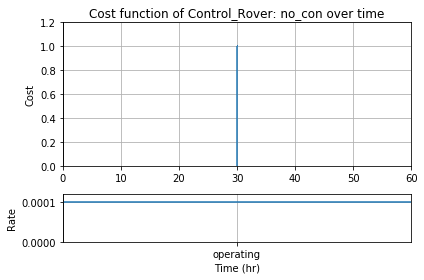

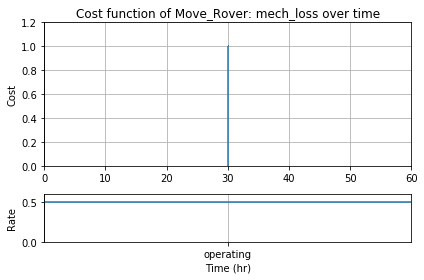

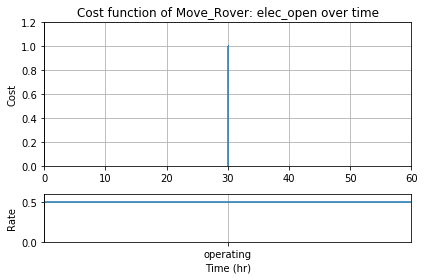

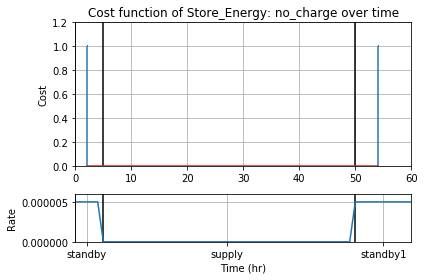

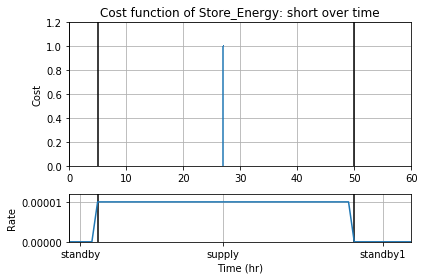

In [49]:
rd.plot.samplecosts(app_correct, endclasses)